In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [2]:
class MultipleScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaler, columns=None):
        """
        Initialize the MultipleScaler

        Parameters
        ----------
        scaler : object
            A scikit-learn scaler instance (e.g., StandardScaler)
        columns : list of int or str, optional
            Columns to scale. If None, all columns will be scaled.
        """
        self.scaler = scaler
        self.columns = columns
        self.scalers_ = {}            # Will hold a separate scaler for each column
        self.columns_to_scale_ = None # Resolved list of column names to scale

    def _ensure_dataframe(self, X):
        """
        Convert input to a DataFrame with proper column names if needed
        """
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        # If columns are missing or are default RangeIndex, assign new names
        if X.columns is None or len(X.columns) == 0 or isinstance(X.columns, pd.RangeIndex):
            X.columns = [f"col_{i}" for i in range(X.shape[1])]
        return X

    def fit(self, X, y=None):
        """
        Fit a separate scaler for each specified column
        """
        X = self._ensure_dataframe(X)
        # Resolve which columns to scale
        if self.columns is None:
            self.columns_to_scale_ = list(X.columns)
        else:
            if all(isinstance(col, int) for col in self.columns):
                try:
                    self.columns_to_scale_ = [X.columns[i] for i in self.columns]
                except IndexError as e:
                    raise ValueError("Column index out of range") from e
            elif all(isinstance(col, str) for col in self.columns):
                missing_cols = [col for col in self.columns if col not in X.columns]
                if missing_cols:
                    raise ValueError(f"Columns not found: {missing_cols}")
                self.columns_to_scale_ = self.columns
            else:
                raise ValueError("Columns must be all integers or all strings")
        # Fit an independent scaler for each column
        for col in self.columns_to_scale_:
            scaler_instance = clone(self.scaler)
            scaler_instance.fit(X[[col]])
            self.scalers_[col] = scaler_instance
        return self

    def transform(self, X):
        """
        Transform each column using its fitted scaler
        """
        X = self._ensure_dataframe(X)
        X_transformed = X.copy()
        # Loop over each column and apply its scaler
        for col, scaler in self.scalers_.items():
            if col in X_transformed.columns:
                X_transformed[col] = scaler.transform(X[[col]]).flatten()
        return X_transformed

    def fit_transform(self, X, y=None):
        """
        Fit scalers and transform the data in one call
        """
        return self.fit(X, y).transform(X)

    def inverse_transform(self, X, scaler_key=None):
        """
        Inverse transform the data using the fitted scaler(s).

        Parameters
        ----------
        X : array-like or DataFrame
            Data with scaled columns to invert.
        scaler_key : str or list/tuple of str, optional
            If provided, use these keys to pick the scalers instead of column names.
        """
        X = self._ensure_dataframe(X)
        X_inversed = X.copy()
        # If a scaler_key is provided, use it for inversion
        if scaler_key is not None:
            if isinstance(scaler_key, str):
                # Use the same scaler for all columns
                if scaler_key not in self.scalers_:
                    raise ValueError(f"Scaler key '{scaler_key}' not found")
                scaler = self.scalers_[scaler_key]
                for col in X_inversed.columns:
                    X_inversed[col] = scaler.inverse_transform(X[[col]]).flatten()
            elif isinstance(scaler_key, (list, tuple)):
                # Use each scaler in order for corresponding columns
                if len(scaler_key) != len(X_inversed.columns):
                    raise ValueError("Length of scaler_key list must equal number of columns")
                for col, key in zip(X_inversed.columns, scaler_key):
                    if key not in self.scalers_:
                        raise ValueError(f"Scaler key '{key}' not found")
                    scaler = self.scalers_[key]
                    X_inversed[col] = scaler.inverse_transform(X[[col]]).flatten()
            else:
                raise ValueError("scaler_key must be a string or list/tuple of strings")
        else:
            # No key provided: use column names to pick scalers
            if len(X_inversed.columns) == 1:
                col = X_inversed.columns[0]
                if col in self.scalers_:
                    scaler = self.scalers_[col]
                elif len(self.scalers_) == 1:
                    scaler = list(self.scalers_.values())[0]
                else:
                    raise ValueError("No matching scaler found")
                X_inversed[col] = scaler.inverse_transform(X[[col]]).flatten()
            else:
                # For each column, match by name
                for col in X_inversed.columns:
                    if col in self.scalers_:
                        X_inversed[col] = self.scalers_[col].inverse_transform(X[[col]]).flatten()
                    else:
                        raise ValueError(f"No scaler found for column '{col}'")
        return X_inversed

    def get_scalers(self):
        """
        Return the dictionary of fitted scalers
        """
        return self.scalers_

In [3]:
def create_synthetic_time_series(n=365):
    """
    Create a synthetic time series with a date index, a target series, and an exogenous feature.
    """
    dates = pd.date_range(start='2020-01-01', periods=n, freq='D')
    np.random.seed(42)

    # Create target with trend, seasonality, and noise
    target = 10 + np.arange(n)*0.05 + 5 * np.sin(np.linspace(0, 3*np.pi, n)) + np.random.normal(0, 1, n)

    # Create exogenous feature with seasonality and noise
    exog = 20 + 10 * np.sin(np.linspace(0, 2*np.pi, n)) + np.random.normal(0, 2, n)
    df = pd.DataFrame({'date': dates, 'target': target, 'exog': exog})
    df.set_index('date', inplace=True)  # Use date as index
    return df

In [4]:
def add_lag_features(df, column, lags):
    """
    Add lagged features for a given column.

    Parameters:
    - df: input DataFrame
    - column: column name to lag
    - lags: list of integers specifying lag periods
    """
    for lag in lags:
        df[f"{column}_lag{lag}"] = df[column].shift(lag)
    return df

In [5]:
def add_date_features(df):
    """
    Extract date-based features (month, day, dayofweek) from the DataFrame index.
    """
    df = df.copy()
    df['month'] = df.index.month              # Month number
    df['day'] = df.index.day                  # Day of month
    df['dayofweek'] = 1 + df.index.dayofweek  # Day of week (1=Monday, 7=Sunday)
    return df

In [6]:
def demo_class_time_series_workflow():
    print("---- Custom Class Approach ----")
    # Create synthetic time series data
    df = create_synthetic_time_series(n=365)
    df = add_date_features(df)  # Add month, day, dayofweek
    df = add_lag_features(df, 'target', lags=[1, 2, 3, 4, 5, 6, 7])  # Create lagged features
    df.dropna(inplace=True)  # Remove rows with NaN lag values

    # Define features and target
    feature_cols = ['exog', 'target_lag1', 'target_lag2', 'month', 'day', 'dayofweek']
    target_col = 'target'

    # Split data into train and test sets (time-ordered)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    # Scale features independently using custom MultipleScaler class
    feature_scaler = MultipleScaler(scaler=StandardScaler(), columns=feature_cols)

    # Scale the target independently (only one column)
    target_scaler = MultipleScaler(scaler=StandardScaler(), columns=[target_col])

    # Fit and transform training features and target
    X_train = feature_scaler.fit_transform(train_df[feature_cols])
    y_train = target_scaler.fit_transform(train_df[[target_col]])

    # Transform test features (using already fitted scalers)
    X_test = feature_scaler.transform(test_df[feature_cols])
    y_test = test_df[[target_col]]  # Keep target in original scale for evaluation

    # Train a regression model on scaled training data
    model = LinearRegression()
    model.fit(X_train, y_train[target_col])

    # Predict on test set (predictions are scaled)
    y_pred_scaled = model.predict(X_test)
    y_pred_scaled_df = pd.DataFrame(y_pred_scaled, index=X_test.index, columns=[target_col])

    # Inverse transform predictions back to original scale using the target scaler
    y_pred_original = target_scaler.inverse_transform(y_pred_scaled_df, scaler_key=target_col)

    # Calculate and print RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
    print(f"Test RMSE (Custom Class): {rmse:.3f}")

    # Plot actual vs. predicted target values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.index, y_test[target_col], label="Actual")
    plt.plot(y_pred_original.index, y_pred_original[target_col], label="Predicted", linestyle='--')
    plt.title("Actual vs. Predicted Target (Custom Class)")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.show()

In [7]:
def demo_procedural_time_series_workflow():
    print("---- Procedural Approach ----")
    # Create synthetic time series data
    df = create_synthetic_time_series(n=365)
    df = add_date_features(df)  # Add date-based features
    df = add_lag_features(df, 'target', lags=[1, 2, 3, 4, 5, 6, 7])  # Add lagged features
    df.dropna(inplace=True)  # Drop rows with NaN values

    # Define features and target
    feature_cols = ['exog', 'target_lag1', 'target_lag2', 'month', 'day', 'dayofweek']
    target_col = 'target'

    # Split into train and test sets (time-ordered)
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    # Procedurally scale each feature independently
    feature_scalers = {}    # Dictionary to hold each feature's scaler
    X_train_proc = train_df[feature_cols].copy()
    X_test_proc = test_df[feature_cols].copy()
    for col in feature_cols:
        scaler = StandardScaler()

        # Fit scaler on training column and transform both train and test
        X_train_proc[col] = scaler.fit_transform(train_df[[col]]).flatten()
        X_test_proc[col] = scaler.transform(test_df[[col]]).flatten()
        feature_scalers[col] = scaler  # Save the scaler for potential use later

    # Scale the target independently
    target_scaler_proc = StandardScaler()
    y_train_proc = target_scaler_proc.fit_transform(train_df[[target_col]])
    y_test_proc = test_df[[target_col]]  # Original scale

    # Train a regression model on the procedurally scaled training data
    model = LinearRegression()
    model.fit(X_train_proc, y_train_proc.ravel())

    # Predict on test set (predictions in scaled space)
    y_pred_scaled_proc = model.predict(X_test_proc)

    # Inverse transform predictions using the target scaler
    y_pred_original_proc = target_scaler_proc.inverse_transform(y_pred_scaled_proc.reshape(-1, 1))

    # Calculate and print RMSE
    rmse_proc = np.sqrt(mean_squared_error(y_test_proc, y_pred_original_proc))
    print(f"Test RMSE (Procedural): {rmse_proc:.3f}")

    # Convert predictions to DataFrame for plotting
    y_pred_original_proc_df = pd.DataFrame(y_pred_original_proc, index=X_test_proc.index, columns=[target_col])

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_proc.index, y_test_proc[target_col], label="Actual")
    plt.plot(y_pred_original_proc_df.index, y_pred_original_proc_df[target_col], label="Predicted", linestyle="--")
    plt.title("Actual vs. Predicted Target (Procedural)")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.show()

---- Custom Class Approach ----
Test RMSE (Custom Class): 0.949


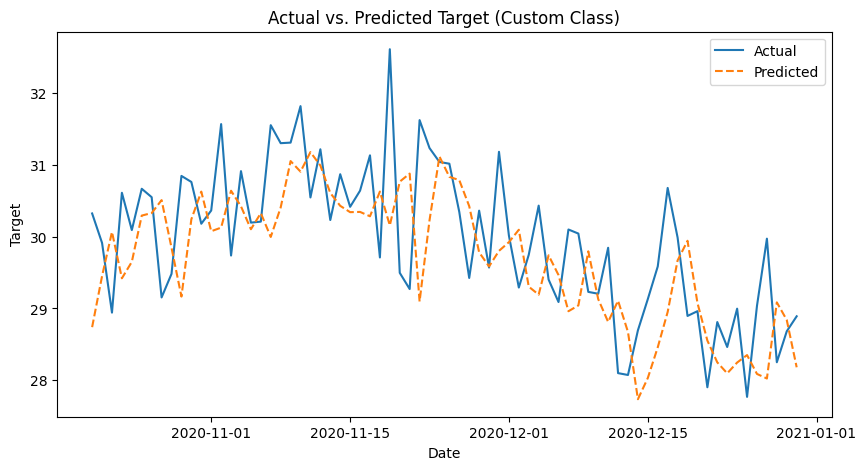

In [8]:
# Run object-oriented workflow
demo_class_time_series_workflow()

---- Procedural Approach ----
Test RMSE (Procedural): 0.949


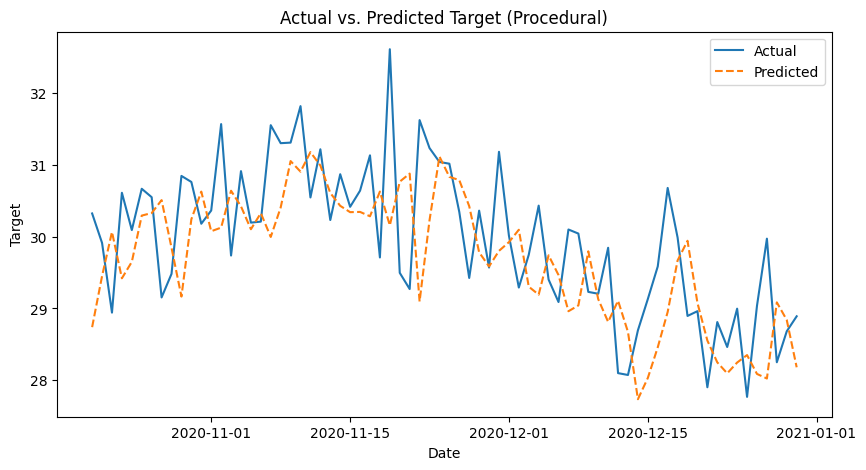

In [9]:
# Run procedural workflow
demo_procedural_time_series_workflow()